In [14]:
import sys
sys.path.append(r"C:\\Users\\QPG\\Downloads\\hardware_control3-master\\hardware_control3-master\\hardware_control3")
import datetime
import numpy as np
from scipy.optimize import *
from santectsl570 import SantecTSL570


### Configure laser & sweep parameters ###
laser = SantecTSL570("GPIB0::19::INSTR")
startWav = laser.get_wavelength()
lamStart = 1515
lamStop = 1525
pwr = 13
speed = 10 #nm/s
trigStep = .002 #output trigger pulse ever X nm
laser.enable_output_trigger(trigStep=trigStep)
scanMode = 1 # one-way continuous scan
nSweeps = 1
tSweep = (lamStop-lamStart)/speed
wav = np.arange(lamStart,lamStop+trigStep,trigStep)

print(laser.wl0)

for i in range(nSweeps):    
    # laser.wavelength_sweep(lamStart,lamStop,pwr,scanMode,speed) #start sweep
    laser.set_wavelength(1550)
    print(laser.get_wavelength())
    print(laser.instr.query('*TST?'))


1.552e-06
1.55e-06
+0


In [2]:
import pyvisa as visa
rm = visa.ResourceManager()
address = "GPIB0::19::INSTR"
instr = rm.open_resource(address)
name = instr.query('*IDN?')

pw = 13

instr.write(f'SOUR:POW {pw}')


13

In [3]:
import pyvisa as visa
import time

rm = visa.ResourceManager()
address = "GPIB0::19::INSTR"
instr = rm.open_resource(address)
name = instr.query('*IDN?')

start_wl = 1500
stop_wl  = 1540
wl = start_wl
step = 0.2
mode = 1
speed = 200

instr.write(f'SOUR:WAV:SWE:STAR {start_wl}nm')
instr.write(f'SOUR:WAV:SWE:STOP {stop_wl}nm')
instr.write(f'SOUR:WAV:SWE:MOD {mode}')
instr.write(f'SOUR:WAV:SWE:SPE {speed}')
instr.write('SOUR:WAV:SWE:STAT 1')

while(int(instr.query('SOUR:WAV:SWE?')) != 0):
    pass

Wavelength: 1549 nm, Intensity: 0.012323824957957454
Wavelength: 1549 nm, Intensity: 0.012652898097136912
Wavelength: 1549.01 nm, Intensity: 0.012817434666775311
Wavelength: 1549.01 nm, Intensity: 0.012981971236446191
Wavelength: 1549.02 nm, Intensity: 0.013146507806149559
Wavelength: 1549.02 nm, Intensity: 0.013146507806149559
Wavelength: 1549.03 nm, Intensity: 0.012488361527530953
Wavelength: 1549.03 nm, Intensity: 0.012323824957957454
Wavelength: 1549.04 nm, Intensity: 0.012159288388416387
Wavelength: 1549.04 nm, Intensity: 0.012488361527530953
Wavelength: 1549.05 nm, Intensity: 0.012159288388416387
Wavelength: 1549.05 nm, Intensity: 0.012159288388416387
Wavelength: 1549.06 nm, Intensity: 0.011501142110576172
Wavelength: 1549.06 nm, Intensity: 0.011336605541197073
Wavelength: 1549.07 nm, Intensity: 0.011007532402535922
Wavelength: 1549.07 nm, Intensity: 0.011007532402535922
Wavelength: 1549.08 nm, Intensity: 0.011336605541197073
Wavelength: 1549.08 nm, Intensity: 0.01100753240253592

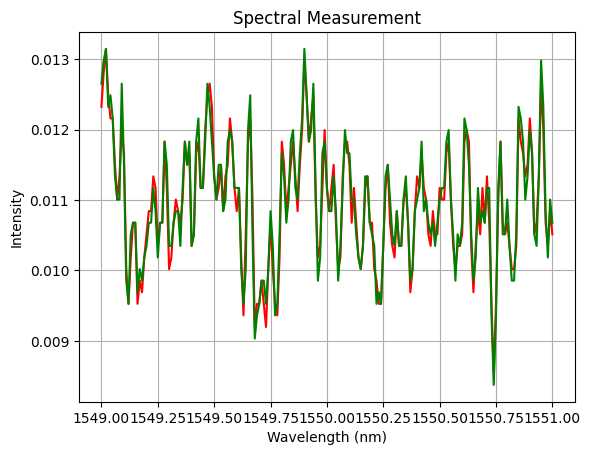

In [1]:
import nidaqmx
import time
from santectsl570 import SantecTSL570
import matplotlib.pyplot as plt
import numpy as np

# Configure laser & sweep parameters
laser = SantecTSL570("GPIB0::19")

task = nidaqmx.Task()  # Instantiate the NI DAQ

task.ai_channels.add_ai_voltage_chan("Dev1/ai0")  # Read out and add the voltage of the channel AI0 which corresponds to Out(1,0)

start_wl = 1549
stop_wl = 1551

wl = start_wl
laser.set_wavelength(start_wl)

sampling_rate = 200000
n_sample = 400

wavelengths = []  # List to store wavelengths
intensities = [[],[]]  # List to store intensities

try:
    while wl < stop_wl:
        # Configure the sampling
        task.timing.cfg_samp_clk_timing(rate=sampling_rate, samps_per_chan=n_sample)
        
        # Read out the task
        data = task.read(number_of_samples_per_channel=n_sample)
        
        # Calculate and append the mean data value
        for i in range(2):
            voltage = data[i]
            mean_value = np.mean(voltage)
            intensities[i].append(mean_value)  # Append intensity
            print(f"Wavelength: {wl} nm, Intensity: {mean_value}")

        wavelengths.append(wl)  # Append current wavelength        
        # Update the wavelength and wait
        wl += 0.01  # nm
        laser.set_wavelength(wl)
        time.sleep(0.01)

    laser.set_wavelength(1550)

    # Plot the acquired data
    plt.plot(wavelengths, intensities[0],color = 'r')
    plt.plot(wavelengths, intensities[1],color = 'g')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.title("Spectral Measurement")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    task.close()  # Close the DAQ task
